In [3]:
import numpy as np
import pandas as pd
from pathlib import Path
import torchaudio
from torch.utils.data import Dataset
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
import librosa
from birdsong_dataset import AudioDataset


In [4]:
df = pd.read_csv("./data/birdsong_metadata.csv")
df.nunique()

file_id                   264
genus                      66
species                    85
english_cname              88
who_provided_recording     68
country                    18
latitude                  195
longitute                 198
type                       54
license                     4
dtype: int64

In [5]:
import torch
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, name , species = sample[0], sample[1],sample[2]

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))[:, :, :141]
        print(image.shape)
        return torch.from_numpy(image) , torch.from_numpy(name) , torch.from_numpy(species)

In [6]:
dataset = AudioDataset(transform = ToTensor())

Loading The Data...
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)
(1, 128, 141)


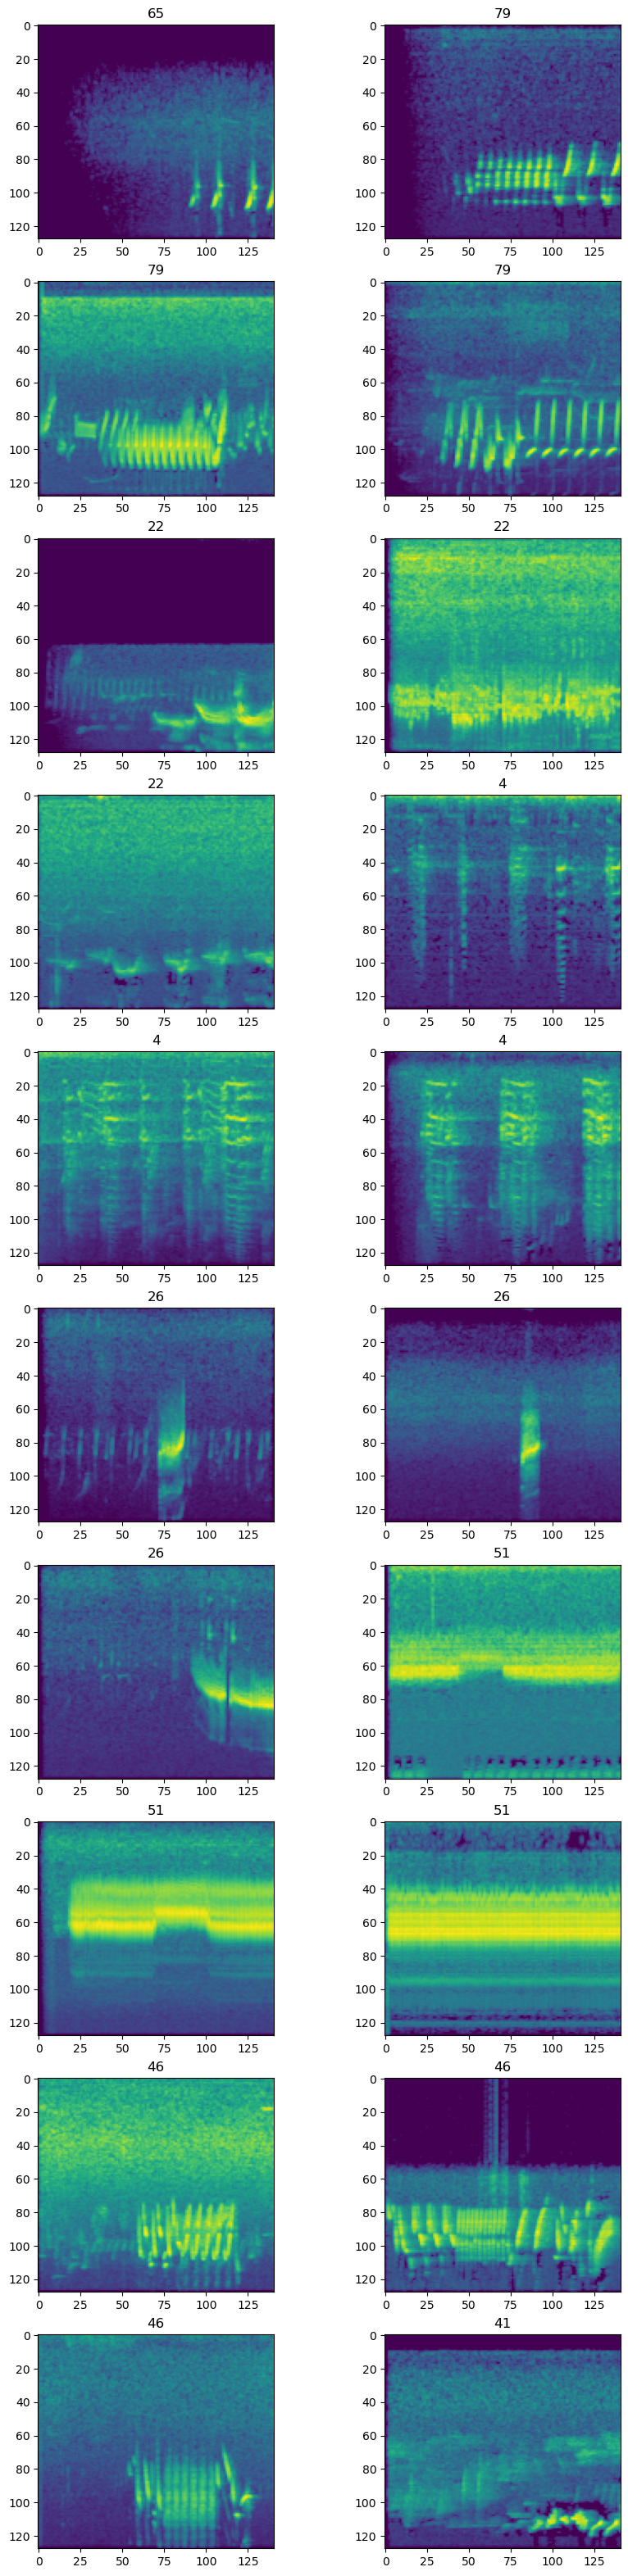

In [146]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10,40))
for i in range(20):
    plt.subplot(10,2,i+1)
    plt.title(dataset[i+20][1].item())
    plt.imshow(dataset[i+20][0].to('cpu').numpy().transpose((1,2,0)))

In [53]:
# len(train_loader) , len(val_loader) , len(test_loader)
# min = 20000
# for (audio , name , species) in train_loader:
#     lenght = audio.shape[3]
#     # print(lenght)
#     if lenght < min : 
#         min = lenght
# print(min)

141


In [149]:
from torch import nn
import torch


class BirdSongClassifier(nn.Module):
    def __init__(self, num_classes_1 = 88 , num_classes_2 = 85):
        super(BirdSongClassifier,self).__init__()
        # backbone
        self.conv1 = nn.Conv2d( in_channels=1, out_channels= 64 , kernel_size=3)
        self.norm1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d((3,3))
        self.conv2 = nn.Conv2d( in_channels=64, out_channels=128 , kernel_size=3)
        self.norm2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d((3,3))
        self.conv3 = nn.Conv2d( in_channels=128, out_channels=64 , kernel_size=3)
        self.norm3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d((3,3))
        
        # multilabel classification for name 
        
        self.names_l1 = nn.Linear(64*3*4 ,512 )
        self.names_relu1 = nn.ReLU()
        self.names_l2 = nn.Linear(512 , num_classes_1 )
        
        # multilabel classification for species       
        
        self.species_l1 = nn.Linear(64*3*4 ,512 )
        self.species_relu1 = nn.ReLU()
        self.species_l2 = nn.Linear(512 , num_classes_2 )
        
    def forward(self,x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.norm1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.norm2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.norm3(x)
        x = self.relu3(x)
        backbone = self.pool3(x)
        # print("Backbone Shape : ", backbone.size())
        #forward for names
        x1 = backbone.view(-1, backbone.size(0) * backbone.size(1) * backbone.size(2))
        # print("X1" , x1.shape)
        x1 = self.names_l1(x1.reshape(-1,768))
        x1 = self.names_relu1(x1)
        x1 = self.names_l2(x1)
        # print("Name Head Shape = " ,x1.shape)

        #forward for species

        x2 = backbone.view(-1, backbone.size(0) * backbone.size(1) * backbone.size(2))
        # print("X2" , x2.shape)
        x2 = self.species_l1(x2.reshape(-1,768))
        x2 = self.species_relu1(x2)
        x2 = self.species_l2(x2)
        # print("Species Head Shape = " ,x2.shape)
        return x1  ,x2

model = BirdSongClassifier()
        

In [150]:
from torch import optim

from torch.utils.data import random_split, DataLoader

# Assuming you have your dataset object named 'dataset' and the total size of the dataset is 'len(dataset)'
# Define the sizes of your desired splits
train_size = int(0.6 * len(dataset))  # 80% of the data for training
val_size = int(0.25 * len(dataset))    # 10% of the data for validation
test_size = len(dataset) - train_size - val_size  # Remaining data for testing

# Use random_split to create the splits
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

batch_size = 2
# You can then create data loaders for each split if needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, )
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define loss function and optimizer
criterion_names = nn.CrossEntropyLoss()
criterion_species = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
model.to("cuda")
# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels_names, labels_species) in enumerate(train_loader):
        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        outputs_names , outputs_species = model(inputs.type(torch.cuda.FloatTensor))
        # print(outputs_names.shape, outputs_species.shape)
        
        # Calculate loss
        loss_names = criterion_names(outputs_names, labels_names.type(torch.cuda.LongTensor) )
        # loss_species = criterion_species(outputs_species, labels_species.type(torch.cuda.LongTensor))
        total_loss = (loss_names) 
                      # + loss_species)
        
        # Backward pass
        total_loss.backward()
        
        # Update weights
        optimizer.step()
        
        running_loss += total_loss.item()
        
        # Print statistics every 100 batches
        if (i + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss / 10:.4f}')
            running_loss = 0.0

print('Finished Training')

Epoch [1/100], Step [10/79], Loss: 14.2297
Epoch [1/100], Step [20/79], Loss: 5.2335
Epoch [1/100], Step [30/79], Loss: 4.5811
Epoch [1/100], Step [40/79], Loss: 4.5236
Epoch [1/100], Step [50/79], Loss: 4.5979
Epoch [1/100], Step [60/79], Loss: 4.6331
Epoch [1/100], Step [70/79], Loss: 4.5573
Epoch [2/100], Step [10/79], Loss: 4.4045
Epoch [2/100], Step [20/79], Loss: 4.5913
Epoch [2/100], Step [30/79], Loss: 4.5535
Epoch [2/100], Step [40/79], Loss: 4.4151
Epoch [2/100], Step [50/79], Loss: 4.3754
Epoch [2/100], Step [60/79], Loss: 4.4027
Epoch [2/100], Step [70/79], Loss: 4.4083
Epoch [3/100], Step [10/79], Loss: 4.4086
Epoch [3/100], Step [20/79], Loss: 4.3665
Epoch [3/100], Step [30/79], Loss: 4.2433
Epoch [3/100], Step [40/79], Loss: 4.4685
Epoch [3/100], Step [50/79], Loss: 5.2262
Epoch [3/100], Step [60/79], Loss: 4.3770
Epoch [3/100], Step [70/79], Loss: 4.4155
Epoch [4/100], Step [10/79], Loss: 4.3797
Epoch [4/100], Step [20/79], Loss: 4.4130
Epoch [4/100], Step [30/79], Loss


KeyboardInterrupt



In [114]:
 # x = dataset[0][0]
# print(x.shape)
# conv1 = nn.Conv2d( in_channels=1, out_channels= 64 , kernel_size=3)(x)
# relu1 = nn.ReLU()(conv1)
# pool1 = nn.MaxPool2d((3,3))(relu1)
# conv2 = nn.Conv2d( in_channels=64, out_channels=128 , kernel_size=3)(pool1)
# relu2 = nn.ReLU()(conv2)
# pool2 = nn.MaxPool2d((3,3))(relu2)
# conv3 = nn.Conv2d( in_channels=128, out_channels=64 , kernel_size=3)(pool2)
# relu3 = nn.ReLU()(conv3)
# pool3 = nn.MaxPool2d((3,3))(relu3)
# print(pool3.shape)



In [ ]:
# sgram = librosa.stft(ds[1][0]
# # librosa.display.specshow(sgram)
# sgram_mag, _ = librosa.magphase(sgram)
# mel_scale_sgram = librosa.feature.melspectrogram(S=sgram_mag, sr=ds[0][1])
# # librosa.display.specshow(mel_scale_sgram)
# mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
# # librosa.display.specshow(mel_sgram, sr=ds[0][1], x_axis='time', y_axis='mel',hop_length=512)